# Measuring Over/Underperformance in Football and putting performance into perspective

Link to player_data.csv: https://drive.google.com/file/d/1zKf8bdZ20PUXB6G033NeizI9jTlFzj5y/view?usp=share_link

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install selenium

In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# Scraping

In [9]:
# @title
base_columns = ['player_name', 'shirt_number', 'nation', 'position', 'age', 'minutes_played']

columns_summary = base_columns + [
'goals', 'assists', 'penalty_kicks_scored', 'penalty_kicks_attempted', 'total_shots', 'shots_on_target',
'yellow_cards', 'red_cards', 'touches', 'tackles', 'interceptions', 'blocks', 'xG', 'npxG', 'xAG',
'shot_creating_actions', 'goal_creating_actions', 'passes_completed', 'passes_attempted', 'pass_compl_perc',
'prog_passes', 'carries', 'prog_carries', 'take_ons_attempted', 'take_ons_successful'
]

columns_passing = base_columns + [
'passes_completed', 'passes_attempted', 'pass_compl_perc', 'total_pass_distance', 'total_prog_pass_distance',
'short_pass_completed', 'short_pass_attempted', 'short_pass_compl_perc', 'medium_pass_completed',
'medium_pass_attempted', 'medium_pass_compl_perc', 'long_pass_completed', 'long_pass_attempted',
'long_pass_compl_perc', 'assists', 'xA', 'xAG', 'key_passes', 'passes_final_third',
'pass_into_penalty_area', 'crosses_into_penalty_area', 'prog_passes'
]

columns_passTypes = base_columns + [
'passes_attempted', 'live_ball_pass', 'dead_ball_pass', 'free_kick_pass', 'through_balls', 'switches', 'crosses', 'throw_ins',
'corner_kick', 'in_corner', 'out_corner', 'straight_corner', 'passes_completed', 'passes_offside', 'passes_blocked'
]

columns_defensiveActions = base_columns + [
'tackles', 'tackles_won', 'tackles_def_3rd', 'tackles_mid_3rd', 'tackles_att_3rd', 'dribblers_tackeled',
'dribbles_challenged', 'dribbles_tackeled_perc', 'challenges_lost', 'total_blocks', 'passes_blocked',
'shots_blocked', 'interceptions', 'tackles_and_interceptions', 'clearances', 'errors'
]

columns_possession = base_columns + [
'touches', 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd', 'touches_att_pen_area',
'live_ball_touches', 'take_ons_attempted', 'take_ons_successful', 'take_ons_success_perc',
'times_tackeled_during_take_on', 'tackeled_during_take_on_perc', 'total_carries', 'total_carrying_distance',
'prog_carrying_distance', 'total_prog_carries', 'carries_into_final_3rd', 'carries_into_penalty_area',
'total_miscontrols', 'dispossessed', 'total_passes_received', 'prog_passes_received'
]

columns_miscanceallousStats = base_columns + [
'yellow_cards', 'red_cards', 'second_yellow_card', 'fouls_committed', 'fouls_drawn', 'offsides', 'crosses',
'interceptions', 'tackles_won', 'penalty_kicks_won', 'penalty_kicks_conceded', 'own_goals', 'ball_recoveries',
'aerials_won', 'aerials_lost', 'aerials_won_perc'
]
all_columns = [
columns_summary,
columns_passing,
columns_passTypes,
columns_defensiveActions,
columns_possession,
columns_miscanceallousStats
]

We scraped data from https://fbref.com/ on all the football games in 8 seasons (2017-2025) for 5 biggest leagues: Premier League, La_Liga, Ligue_1, Bundesliga, Serie_A.

BeautifulSoup and Selenium to scrape data from the website.

ThreadPoolExecutor to split and use several of browsers simultaneously to save parsing time


1. Scrape links to the pages with information on 5 biggest leagues from the table on the main page by id
2. Scrape links to 8 seasons for each league
3. In each season web page get links to the pages with reports on all the held matches
4. On the page of each specific game scrape all the possible data for activity and performance of every player during this game

In [ ]:
base_url = 'https://fbref.com'

options = Options()
# options.add_argument("--headless=new")
n = 5
def close_stathead_popup(driver):
    try:
        wait = WebDriverWait(driver, 2)
        close_btn = wait.until(EC.presence_of_element_located((By.ID, "modal-close")))
        driver.execute_script("arguments[0].scrollIntoView(true);", close_btn)
        time.sleep(0.3)
        driver.execute_script("arguments[0].click();", close_btn)
        time.sleep(0.5)
    except:
        pass

def scrape_game_with_pool(driver, href, home_team, away_team, league, season, all_columns):
    print(f"Scraping match: {home_team} vs {away_team} ({league} {season})")
    driver.get(base_url + href)
    close_stathead_popup(driver)
    soup_new = BeautifulSoup(driver.page_source, "html.parser")
    tables = soup_new.find('table')

    dict_home = {'league': [league]*16, 'season':[season]*16, 'team':[home_team]*16, 'home_away':['home']*16}
    game_home = pd.DataFrame(dict_home)
    for j in range(-12, -18, -1):
        rows = tables[j].find_all('tr')
        metrics = []
        for row in rows[2:-1]:
            names = [th.get_text(strip=True) for th in row.find_all('th')]
            cells = [td.get_text() for td in row.find_all('td')]
            names.extend(cells)
            metrics.append(names)
        data = pd.DataFrame(metrics, columns=all_columns[j+17])
        game_home = pd.concat([game_home, data], axis=1)
    game_home = game_home.loc[:, ~game_home.columns.duplicated()]

    dict_away = {'league': [league]*16, 'season':[season]*16, 'team':[away_team]*16, 'home_away':['away']*16}
    game_away = pd.DataFrame(dict_away)
    for j in range(-5, -11, -1):
        rows = tables[j].find_all('tr')
        metrics = []
        for row in rows[2:-1]:
            names = [th.get_text(strip=True) for th in row.find_all('th')]
            cells = [td.get_text() for td in row.find_all('td')]
            names.extend(cells)
            metrics.append(names)
        data = pd.DataFrame(metrics, columns=all_columns[j+10])
        game_away = pd.concat([game_away, data], axis=1)
    game_away = game_away.loc[:, ~game_away.columns.duplicated()]

    return pd.concat([game_home, game_away], ignore_index=True)

def get_data():

    browsers = [webdriver.Chrome(options=options) for _ in range(5)]
    driver_main = browsers[0]
    driver_main.get(f"{base_url}/en/comps/")
    soup = BeautifulSoup(driver_main.page_source, "html.parser")
    league_table = soup.find('table', {'id': 'coms_club'})
    rows = league_table.find_all('tr')
    hrefs_leagues = [row.find_all('th')[0].find('a', href=True)['href'] for row in rows[1:-1]]
    leagues_list = ['Premier_League', 'La_Liga', 'Ligue_1', 'Bundesliga', 'Serie_A']

    for l in range(len(leagues_list)):
        league = leagues_list[l]
        league_href = hrefs_leagues[l]
        print(f"Processing league: {league}")
        driver_main.get(base_url + league_href)
        soup_league = BeautifulSoup(driver_main.page_source, "html.parser")
        table_seasons = soup_league.find('table', {'id': 'seasons'})
        rows_seasons = table_seasons.find_all('tr')[2:10]
        # print(rows_seasons)
        hrefs_seasons = []
        seasons = []
        for row in rows_seasons:
            links = row.find_all('th')[0].find_all('a', href=True)
            if links:
                link_parts = links[0]['href'].split('/')
                hrefs_seasons.append('/'.join(link_parts[:5]) + '/schedule/' + link_parts[5][:-5] + 'Scores-and-Fixtures')
                seasons.append(link_parts[5][:4].replace('_',''))

    for season_href, season in zip(hrefs_seasons, seasons):
        print(f"  Season: {season}")
        driver_main.get(base_url + season_href)
        soup_season = BeautifulSoup(driver_main.page_source, "html.parser")
        table_reports = soup_season.find('table', id=lambda x: x and f"sched_{season}-{int(season)+1}" in x)
        rows_matches = table_reports.find_all('tr')

        hrefs_reports, home_teams, away_teams = [], [], []
        for row in rows_matches[1:]:
            cells = row.find_all('td')
            values = [cell.get_text(strip=True) for cell in cells]
            if values and values[0] != '' and values[-2] == 'Match Report':
                home_teams.append(values[3])
                away_teams.append(values[7])
                hrefs_reports.append(cells[-2].find('a', href=True)['href'])

        season_data = pd.DataFrame()
        with ThreadPoolExecutor(max_workers=n) as executor:
            futures = {}
            for i, (href, home, away) in enumerate(zip(hrefs_reports, home_teams, away_teams)):
                driver_instance = browsers[i % n]
                futures[executor.submit(scrape_game_with_pool, driver_instance, href, home, away, league, season, all_columns)] = (home, away)

            for future in as_completed(futures):
                season_data = pd.concat([season_data, future.result()], ignore_index=True)

        season_data.to_csv(f'{league}_{season}.csv', sep=',', index=False)

    for b in browsers:
        b.quit()

get_data()


# Dataset

In [10]:
main_df = pd.read_csv('player_data.csv', sep=',')

In [11]:
print(main_df.shape)
pd.set_option('display.max_columns', None)
display(main_df.head())
#pd.reset_option('display.max_columns')

(423662, 107)


,league,season,team,home_away,player_name,shirt_number,nation,position,age,minutes_played,yellow_cards,red_cards,second_yellow_card,fouls_committed,fouls_drawn,offsides,crosses,interceptions,tackles_won,penalty_kicks_won,penalty_kicks_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_perc,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,live_ball_touches,take_ons_attempted,take_ons_successful,take_ons_success_perc,times_tackeled_during_take_on,tackeled_during_take_on_perc,total_carries,total_carrying_distance,prog_carrying_distance,total_prog_carries,carries_into_final_3rd,carries_into_penalty_area,total_miscontrols,dispossessed,total_passes_received,prog_passes_received,tackles,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribblers_tackeled,dribbles_challenged,dribbles_tackeled_perc,challenges_lost,total_blocks,passes_blocked,shots_blocked,tackles_and_interceptions,clearances,errors,passes_attempted,live_ball_pass,dead_ball_pass,free_kick_pass,through_balls,switches,throw_ins,corner_kick,in_corner,out_corner,straight_corner,passes_completed,passes_offside,pass_compl_perc,total_pass_distance,total_prog_pass_distance,short_pass_completed,short_pass_attempted,short_pass_compl_perc,medium_pass_completed,medium_pass_attempted,medium_pass_compl_perc,long_pass_completed,long_pass_attempted,long_pass_compl_perc,assists,xA,xAG,key_passes,passes_final_third,pass_into_penalty_area,crosses_into_penalty_area,prog_passes,goals,penalty_kicks_scored,penalty_kicks_attempted,total_shots,shots_on_target,blocks,xG,npxG,shot_creating_actions,goal_creating_actions,carries,prog_carries
0,Premier_League,17_18,Arsenal,home,Alexandre Lacazette,9.0,fr FRA,"FW,LW,LM",26-075,90.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,33.3,34.0,1.0,2.0,9.0,23.0,6.0,34.0,1.0,1.0,100.0,0.0,0.0,19.0,50.0,27.0,1.0,0.0,1.0,2.0,2.0,25.0,10.0,2.0,0.0,1.0,1.0,1.0,3.0,33.3,2.0,1.0,0.0,1.0,2.0,1.0,0.0,24.0,19.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0,83.3,263.0,42.0,14.0,16.0,87.5,5.0,6.0,83.3,0.0,0.0,NaN,0.0,0.4,0.2,3.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,3.0,2.0,1.0,0.3,0.3,6.0,2.0,19.0,1.0
1,Premier_League,17_18,Arsenal,home,Danny Welbeck,23.0,eng ENG,"AM,FW",26-258,74.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,50.0,31.0,1.0,6.0,7.0,18.0,5.0,31.0,2.0,2.0,100.0,0.0,0.0,18.0,130.0,47.0,3.0,1.0,2.0,1.0,4.0,22.0,6.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,21.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,76.2,190.0,33.0,13.0,16.0,81.3,2.0,2.0,100.0,0.0,0.0,NaN,0.0,0.4,0.2,2.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,3.0,1.0,0.0,1.0,1.0,4.0,0.0,18.0,3.0
2,Premier_League,17_18,Arsenal,home,Theo Walcott,14.0,eng ENG,RW,28-148,16.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,NaN,0.0,NaN,2.0,12.0,11.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.0,11.0,0.0,1.0,1.0,100.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0
3,Premier_League,17_18,Arsenal,home,Mesut Özil,11.0,de GER,"AM,RM",28-300,90.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,95.0,1.0,9.0,34.0,53.0,3.0,95.0,2.0,2.0,100.0,0.0,0.0,69.0,390.0,132.0,3.0,7.0,0.0,3.0,3.0,83.0,17.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,86.0,81.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,70.0,2.0,81.4,981.0,163.0,45.0,48.0,93.8,18.0,21.0,85.7,3.0,6.0,50.0,0.0,0.6,0.2,6.0,4.0,2.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,1.0,0.1,0.1,10.0,0.0,69.0,3.0
4,Premier_League,17_18,Arsenal,home,Granit Xhaka,29.0,ch SUI,"CM,DM",24-318,90.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,0.0,114.0,1.0,13.0,67.0,34.0,0.0,114.0,1.0,1.0,100.0,0.0,0.0,80.0,331.0,200.0,4.0,4.0,0.0,1.0,0.0,89.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,106.0,94.0,12.0,3.0,1.0,3.0,1.0,8.0,3.0,2.0,0.0,86.0,0.0,81.1,1845

# Analysis

Analysis provides insights on both separate players and whole teams. Main questions we aim to answer:

* How accurate are players in passing given their willingness to take risks?
* How efficient are players in converting actions on the ball in the final third into actual shots?
*  Which players/teams over/underperform compared to expected goals?
*  How do teams' non-penalty expected goals compare to non-penalty expected goals against over seasons?

In [12]:
def scatterplot_no_season(stats, conditions, title, xlabel, ylabel, label_mode=0, q_x=None, q_y=None, q_playtime=None, q_label=1, team=None, season=None, position=None):
  x_axis = stats.iloc[:, 1]
  y_axis = stats.iloc[:, 2]
  positions, teams, minutes_played = conditions['position'], conditions['team'], conditions['minutes_played']
  if label_mode == 0:
    labels = conditions['player_name']
  elif label_mode == 1:
    labels = conditions['player_name'] + ' (' + conditions['team'] + ')'
  elif label_mode == 2:
    labels = conditions['player_name'] + ' (' + conditions['team'] + ', ' + conditions['position'] + ')'
  elif label_mode == 3:
    labels = conditions['player_name'] + ' (' + conditions['team'] + ', ' + conditions['position'] + ', ' + conditions['season'] + ')'
  if q_x:
    mask = x_axis > x_axis.quantile(q_x)
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if q_y:
    mask = y_axis > y_axis.quantile(q_y)
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if q_playtime:
    mask = minutes_played > minutes_played.quantile(q_playtime)
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if team:
    mask = teams == team
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if position:
    mask = positions == position
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  plt.figure(figsize=(15, 6))
  plt.scatter(x_axis, y_axis, alpha=0.8, edgecolor='k')
  for x, y, label in zip(x_axis, y_axis, labels):
      if x > x_axis.quantile(q_label) or y > y_axis.quantile(q_label):
          plt.text(x, y, label, fontsize=6, alpha=0.8)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xlim((x_axis.min() * 0.95, x_axis.max() * 1.05))
  plt.ylim((y_axis.min() * 0.95, y_axis.max() * 1.05))
  plt.show()

def scatterplot_season(stats, conditions, title, xlabel, ylabel, label_mode=0, q_x=None, q_y=None, q_playtime=None, q_label=1, team=None, season=None, position=None):
  x_axis = stats.iloc[:, 2]
  y_axis = stats.iloc[:, 3]
  positions, teams, minutes_played, seasons = conditions['position'], conditions['team'], conditions['minutes_played'], conditions['season']
  if label_mode == 0:
    labels = conditions['player_name']
  elif label_mode == 1:
    labels = conditions['player_name'] + ' (' + conditions['team'] + ')'
  elif label_mode == 2:
    labels = conditions['player_name'] + ' (' + conditions['team'] + ', ' + conditions['position'] + ')'
  elif label_mode == 3:
    labels = conditions['player_name'] + ' (' + conditions['team'] + ', ' + conditions['position'] + ', ' + conditions['season'] + ')'
  if q_x:
    mask = x_axis > x_axis.quantile(q_x)
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if q_y:
    mask = y_axis > y_axis.quantile(q_y)
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if q_playtime:
    mask = minutes_played > minutes_played.quantile(q_playtime)
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if team:
    mask = teams == team
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if season:
    mask = seasons == season
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]
  if position:
    mask = positions == position
    x_axis = x_axis[mask]
    y_axis = y_axis[mask]
    labels = labels[mask]

  plt.figure(figsize=(15, 6))
  plt.scatter(x_axis, y_axis, alpha=0.8, edgecolor='k')
  for x, y, label in zip(x_axis, y_axis, labels):
      if x > x_axis.quantile(q_label) or y > y_axis.quantile(q_label):
          plt.text(x, y, label, fontsize=6, alpha=0.8)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xlim((x_axis.min() * 0.95, x_axis.max() * 1.05))
  plt.ylim((y_axis.min() * 0.95, y_axis.max() * 1.05))
  plt.show()

In [13]:
#group only by player name
positions = main_df.groupby('player_name')['position'].first()
teams = main_df.groupby('player_name')['team'].first()
minutes = main_df.groupby('player_name')[['minutes_played']].sum()
conditions_alltime = pd.concat([positions, teams, minutes], axis=1).reset_index()

#group by player name and season
positions = main_df.groupby(['season', 'player_name'])['position'].first()
teams = main_df.groupby(['season', 'player_name'])['team'].first()
minutes = main_df.groupby(['season', 'player_name'])[['minutes_played']].sum()
seasons = main_df.groupby(['season', 'player_name'])['season'].first()
conditions_season = pd.concat([positions, teams, minutes], axis=1).reset_index()

## Goals vs Assists

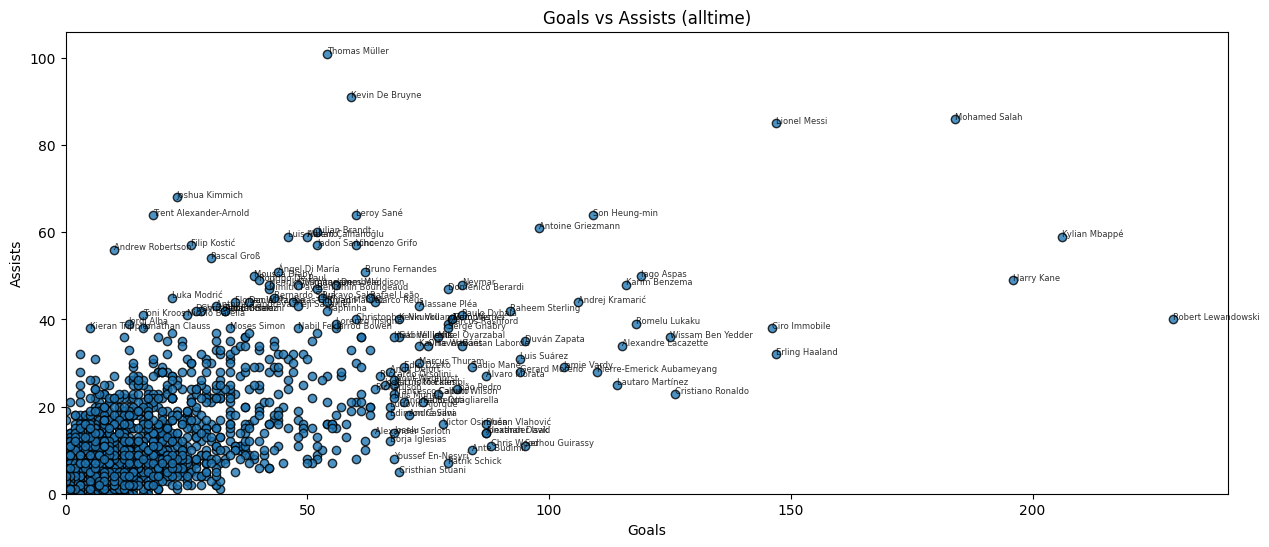

In [14]:
#goals vs assists alltime
stats = main_df.groupby('player_name')[['goals', 'assists']].sum().reset_index()
scatterplot_no_season(stats, conditions_alltime, 'Goals vs Assists (alltime)', 'Goals', 'Assists', label_mode=0, q_label = 0.99)

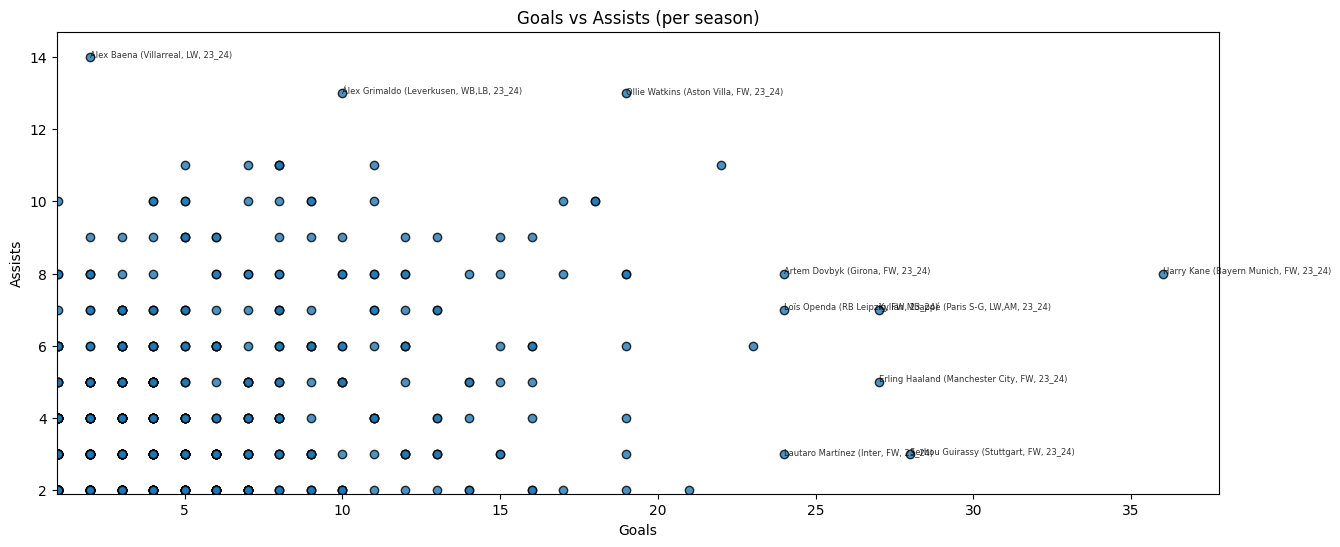

In [15]:
#goals vs assists per season
stats = main_df.groupby(['season', 'player_name'])[['goals', 'assists']].sum().reset_index()
scatterplot_season(stats, conditions_season, 'Goals vs Assists (per season)', 'Goals', 'Assists', label_mode=3, q_x = 0.5, q_y=0.5, q_playtime = 0.2, q_label=0.99, season='23_24')

# Passing and Shot creation

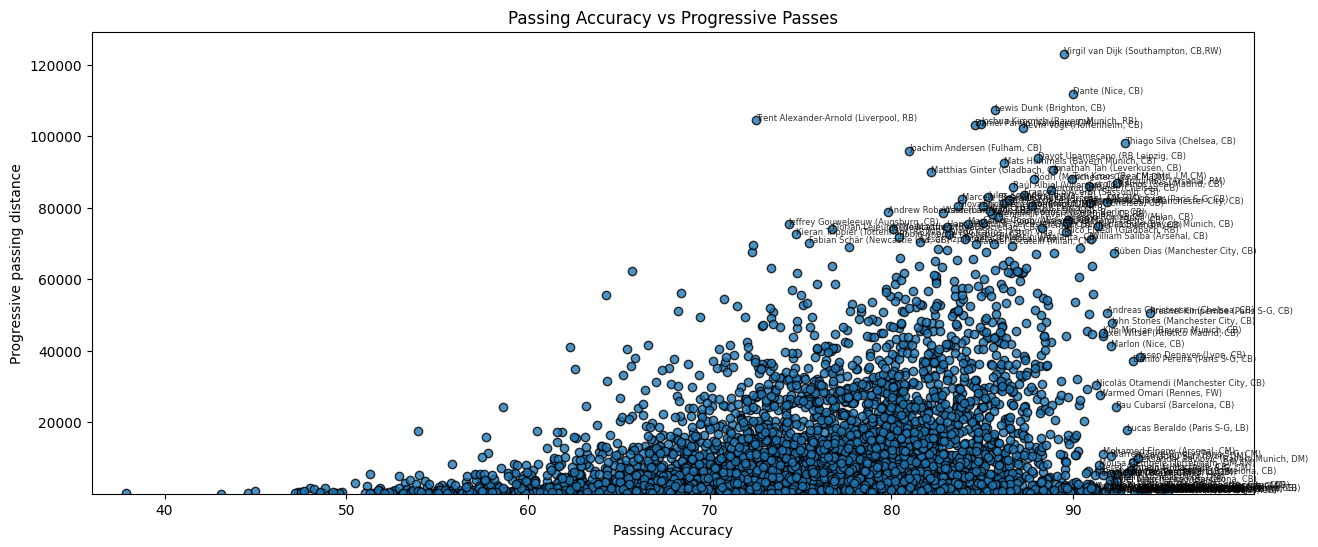

In [16]:
info = main_df.groupby('player_name')['position'].first()
pass_compl = main_df.groupby('player_name')['pass_compl_perc'].mean()
prog_pass = main_df.groupby('player_name')[['minutes_played', 'total_prog_pass_distance']].sum()
data = pd.concat([info, pass_compl, prog_pass], axis=1).reset_index()

stats_passing = data[['player_name', 'pass_compl_perc', 'total_prog_pass_distance', 'position']]
stats_passing = stats_passing[stats_passing['position'] != 'GK']
stats_passing.drop('position', axis =1)
conditions_alltime_new= conditions_alltime[conditions_alltime['player_name'].isin(stats_passing['player_name'])]
scatterplot_no_season(stats_passing, conditions_alltime_new, 'Passing Accuracy vs Progressive Passes', 'Passing Accuracy', 'Progressive passing distance', 2, q_playtime = 0.2, q_label = 0.99)


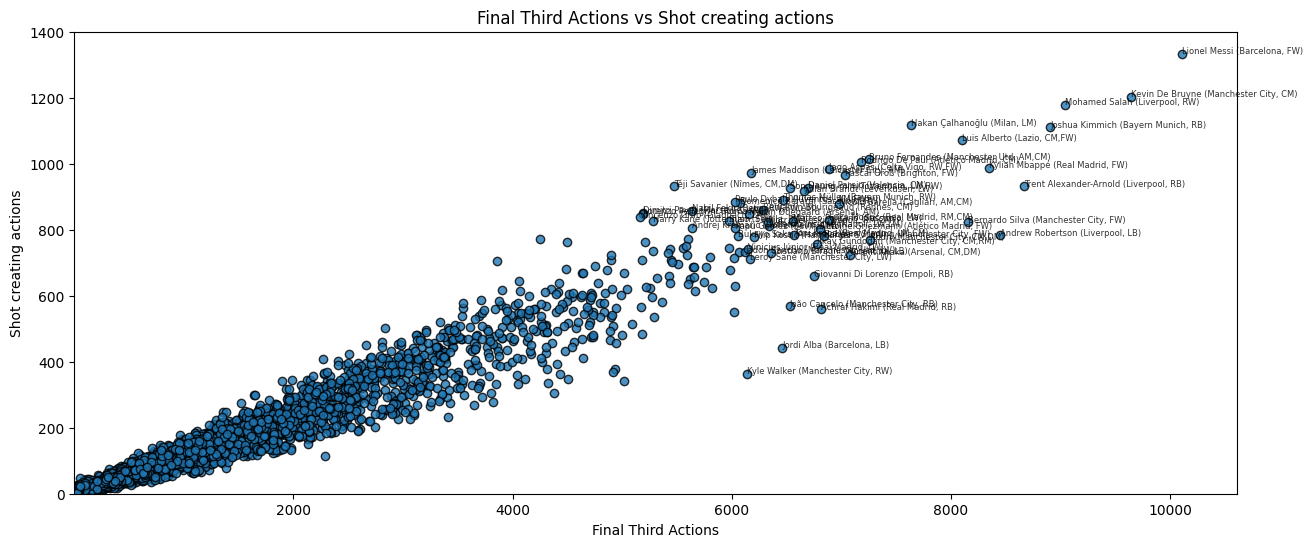

[]

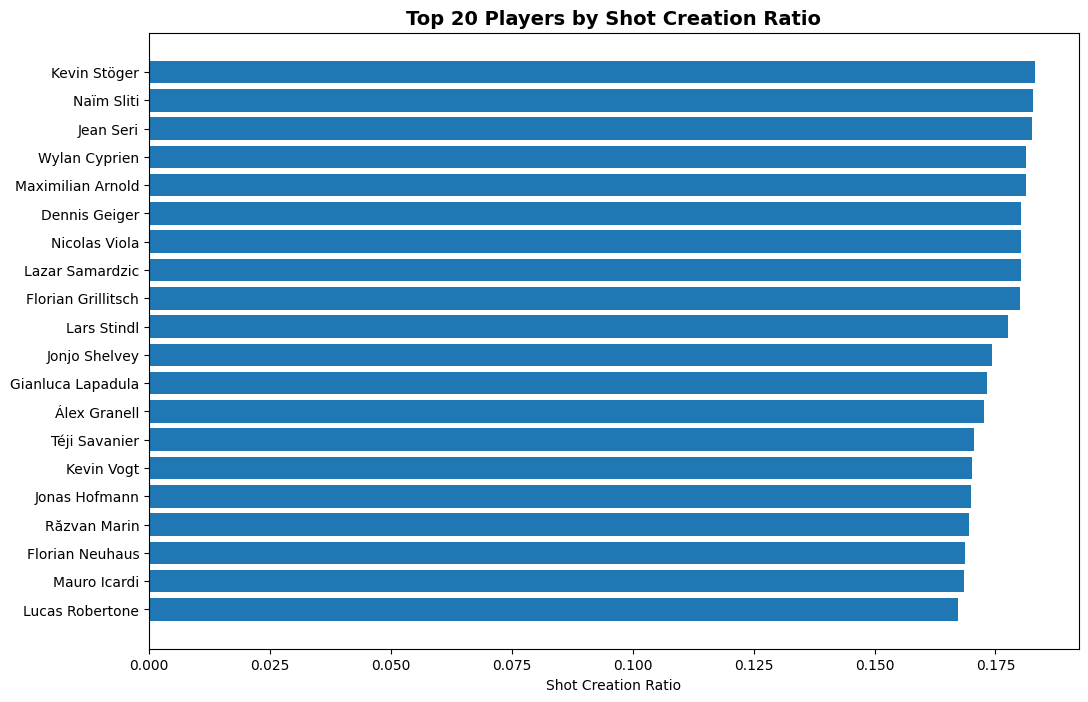

In [18]:
#attacking third appeareances vs shot creating actions and xG creating actions (xAG)
#xAG sum of xG created by the player through passes

#position = main_df.groupby('player_name')['position'].first()
stats = main_df.groupby('player_name')[['minutes_played', 'carries_into_final_3rd', 'passes_final_third',
                                        'touches_att_3rd', 'shot_creating_actions']].sum().reset_index()

#stats = pd.concat([position, stats], axis=1).reset_index()
stats['final_third_actions'] = stats['carries_into_final_3rd'] + stats['passes_final_third'] + stats['touches_att_3rd']
stats = stats[stats['final_third_actions'] != 0]
stats['shot_creation_ratio'] = stats['shot_creating_actions']/stats['final_third_actions']

stats_scatter = stats[['player_name', 'final_third_actions', 'shot_creating_actions']]
conditions_alltime_new= conditions_alltime[conditions_alltime['player_name'].isin(stats['player_name'])]
scatterplot_no_season(stats_scatter, conditions_alltime_new, 'Final Third Actions vs Shot creating actions', 'Final Third Actions', 'Shot creating actions', 2, q_playtime = 0.4, q_label = 0.99)

#ratios
th_min = 0 #data['minutes_played'].quantile(0.1)
th_final3rd = 1000 #data['final_third_actions'].quantile(0.1)
stats = stats[(stats['minutes_played'] > th_min) & (conditions_alltime_new['position'] != 'GK') &(stats['final_third_actions'] > th_final3rd)]
# print(stats['position'].unique())

# stats = stats[stats['position'].str.contains('RB', na=False)]

top_shot = stats.sort_values('shot_creation_ratio', ascending=False).head(20)

plt.figure(figsize=(12, 8))
plt.barh(top_shot['player_name'], top_shot['shot_creation_ratio'])
plt.gca().invert_yaxis()
plt.title(f'Top 20 Players by Shot Creation Ratio', fontsize=14, weight='bold')
plt.xlabel('Shot Creation Ratio')
plt.plot()

# Over/Underperfomance - What is a player's/team's goal output compared to what it should be?
Comparing expected goals (xG) with actual scored goals and expected assists (xA) with actual assists.

xG: the probability that a shot will result in a goal based on the characteristics of that shot and the events leading up to it
- location of shooter
- pressure by defenders
- path to the goal
- many more...

xA: the likelihood that a given completed pass will become a goal assist, players receive xA for every completed pass regardless of whether a shot occurred or not
a high xA indicates a player is able to create chances with high quality at a high frequency

Why would be Assists - xA not a good indicator for a players performance?

Goals - xG:
- indicates a players shooting ability or luck
- players consistently outperforming their expected output have an above average shooting/finishing ability

https://fbref.com/en/expected-goals-model-explained/

In [19]:
#goals and assists vs xG and xA
print(main_df['goals'].sum())
print(main_df['xG'].sum())
print(main_df['assists'].sum())
print(main_df['xA'].sum())

38848.0
39054.5
27235.0
27250.200000000008


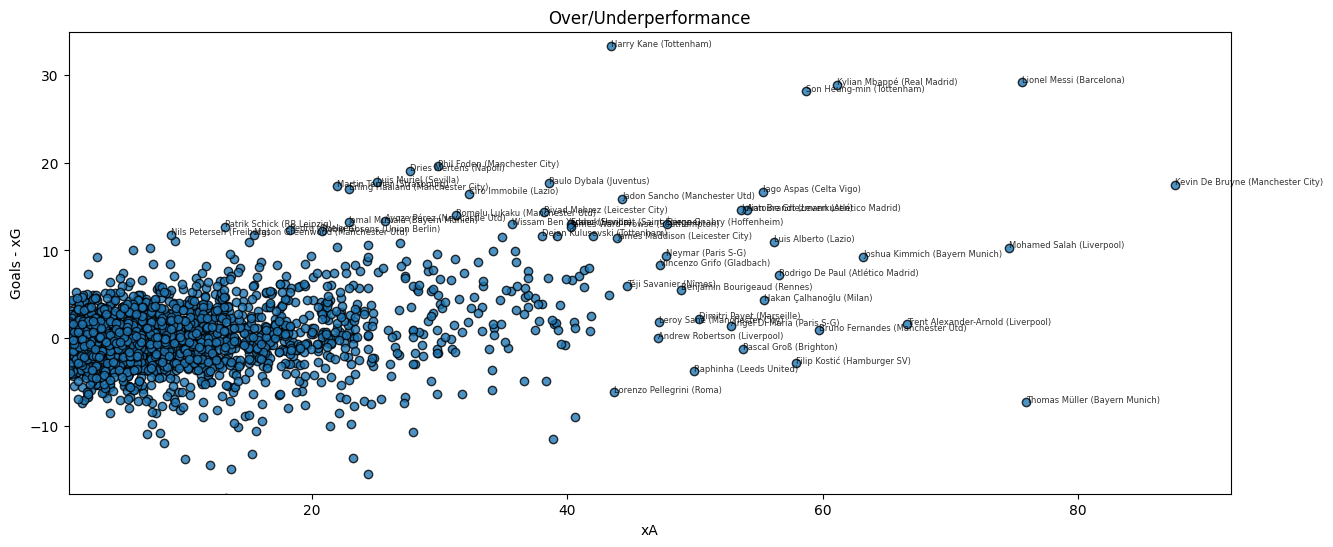

In [20]:
#Over/Underperformance of individual players, all time
stats = main_df.groupby('player_name')[['goals', 'xG', 'xA']].sum().reset_index()
stats['goal_diff'] = stats['goals'] - stats['xG']
stats = stats.drop(['goals', 'xG'], axis=1)
scatterplot_no_season(stats, conditions_alltime, 'Over/Underperformance', 'xA', 'Goals - xG', label_mode=1, q_x = 0.5, q_playtime=0.5, q_label=0.99)

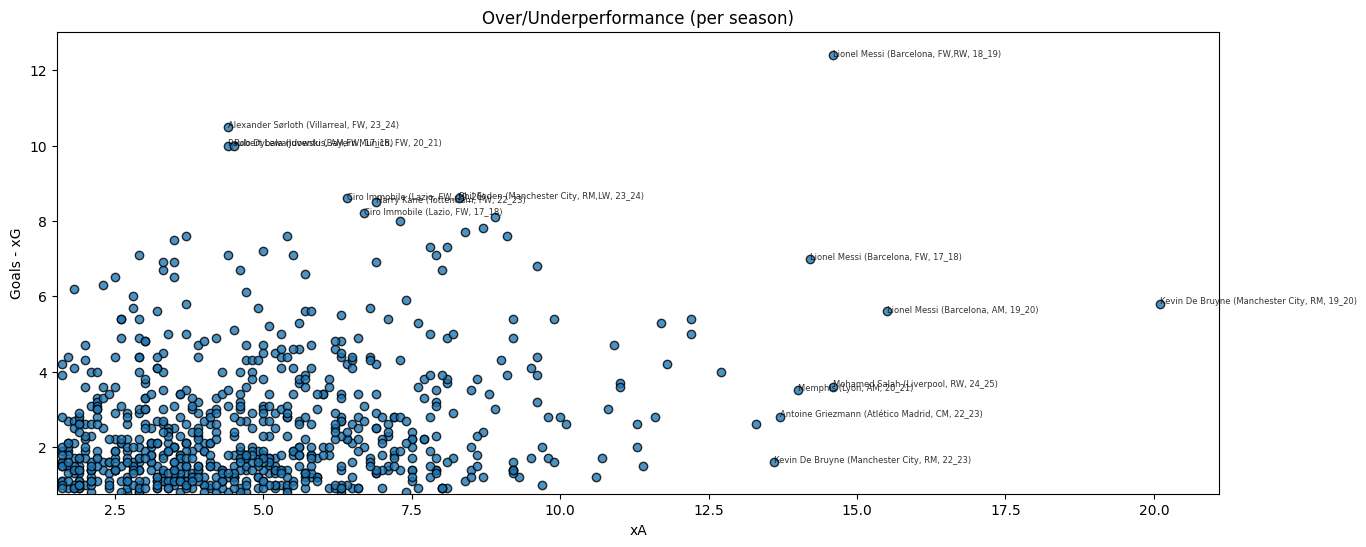

In [21]:
#over/underperformance per season
stats = main_df.groupby(['season', 'player_name'])[['goals', 'xG', 'xA']].sum().reset_index()
stats['goal_diff'] = stats['goals'] - stats['xG']
stats = stats.drop(['goals', 'xG'], axis=1)
scatterplot_season(stats, conditions_season, 'Over/Underperformance (per season)', 'xA', 'Goals - xG', label_mode=3, q_x=0.7, q_y=0.7, q_playtime=0.8, q_label=0.99)

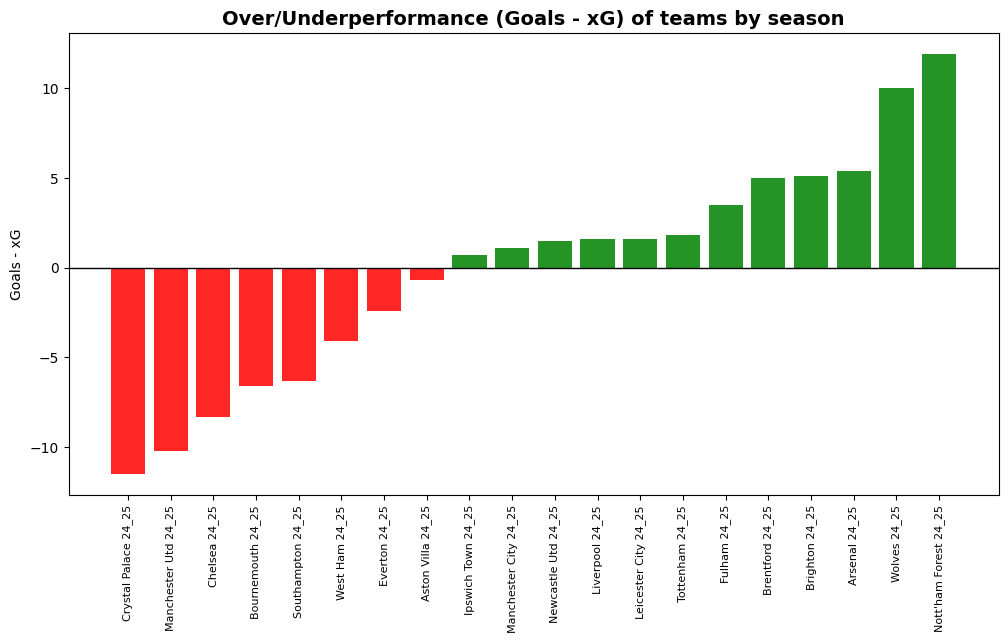

In [22]:
#Over/Underperformance of teams, split by season
data = main_df.groupby(['league', 'season', 'team'])[['goals', 'xG']].sum().reset_index()

data['goal_diff'] = data['goals'] - data['xG']

data = data[data['league'] == 'Premier_League']
data = data[data['season'] == '24_25']

data['team_season'] = data['team'] + ' ' + data['season'].astype(str)
top = data.sort_values('goal_diff', ascending=False).head(10)
bottom = data.sort_values('goal_diff', ascending=True).head(10)

#display(top, bottom)

combined = pd.concat([bottom, top]).sort_values('goal_diff', ascending=True)

colors = ['red' if x < 0 else 'green' for x in combined['goal_diff']]

plt.figure(figsize=(12, 6))
plt.bar(combined['team_season'], combined['goal_diff'], color=colors, alpha=0.85)
plt.axhline(0, color='black', linewidth=1)
plt.title('Over/Underperformance (Goals - xG) of teams by season', fontsize=14, weight='bold')
plt.ylabel('Goals - xG')
plt.xticks(rotation=90, fontsize=8)
plt.show()

# Attacking and defending performances over time
The following plot shows the 6 games rolling average of xG for and xG against a certain team.

In [23]:
df = main_df.copy().reset_index(drop=True)

In [24]:
game_indices = []
current_home = df.loc[0, 'team']
start_idx = 0

for i in range(1, len(df)):

    if df.loc[i, 'home_away'] == 'home' and df.loc[i, 'team'] != df.loc[i-1, 'team']:
        game_indices.append((start_idx, i - 1))
        start_idx = i

game_indices.append((start_idx, len(df) - 1))
matches = []
for start, end in game_indices:
    game_df = df.loc[start:end]
    teams = game_df['team'].unique()
    home_team = game_df.loc[game_df['home_away'] == 'home', 'team'].iloc[0]
    away_team = game_df.loc[game_df['home_away'] == 'away', 'team'].iloc[0]
    home_xg = game_df.loc[game_df['home_away'] == 'home', 'npxG'].sum()
    away_xg = game_df.loc[game_df['home_away'] == 'away', 'npxG'].sum()

    matches.append({
        'league': game_df['league'].iloc[0],
        'season': game_df['season'].iloc[0],
        'home_team': home_team,
        'away_team': away_team,
        'home_xG_for': home_xg,
        'away_xG_for': away_xg,
    })

matches_df = pd.DataFrame(matches)

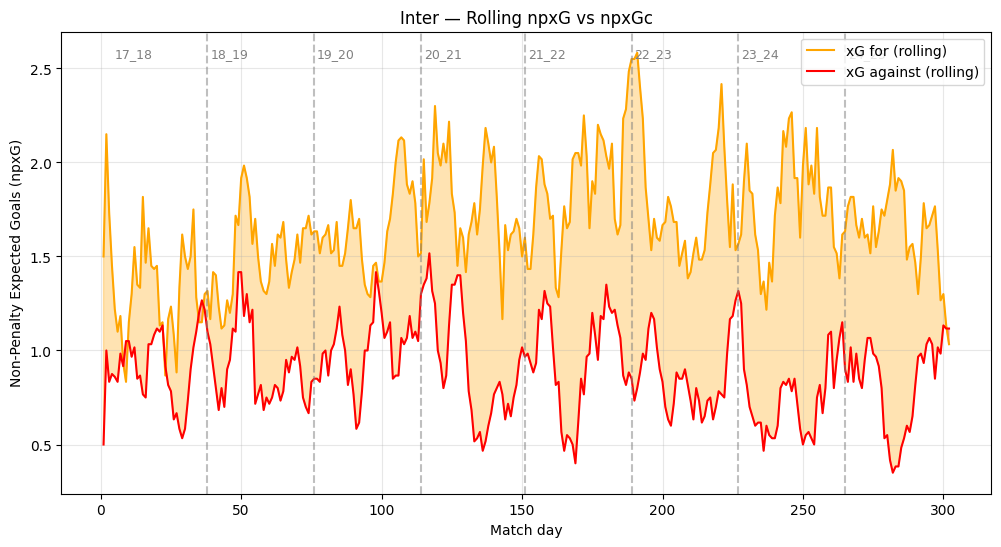

In [25]:
def plot_rolling_xg(df, team, seasons=None, window = 6):

    team_matches = []

    for _, row in matches_df.iterrows():
        if row['home_team'] == team:
            team_matches.append({
                'team': team,
                'opponent': row['away_team'],
                'home_away': 'home',
                'npxG_for': row['home_xG_for'],
                'npxG_against': row['away_xG_for'],
                'season': row['season']
            })
        elif row['away_team'] == team:
            team_matches.append({
                'team': team,
                'opponent': row['home_team'],
                'home_away': 'away',
                'npxG_for': row['away_xG_for'],
                'npxG_against': row['home_xG_for'],
                'season': row['season']
            })

    df = pd.DataFrame(team_matches)
    df['match_day'] = range(1, len(df)+1)
    df['xG_for_roll'] = df['npxG_for'].rolling(window, min_periods = 1).mean()
    df['xG_against_roll'] = df['npxG_against'].rolling(window, min_periods = 1).mean()
    if seasons is not None:
      df = df[df['season'].isin(seasons)]
      df = df.sort_values(['season', 'match_day']).reset_index(drop=True)
    df['match_number_cont'] = range(1, len(df) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(df['match_number_cont'], df['xG_for_roll'], color='orange', label='xG for (rolling)')
    plt.plot(df['match_number_cont'], df['xG_against_roll'], color='red', label='xG against (rolling)')

    plt.fill_between(df['match_number_cont'], df['xG_for_roll'], df['xG_against_roll'],
        where=(df['xG_for_roll'] > df['xG_against_roll']),
        color='orange', alpha=0.3, interpolate=True)
    plt.fill_between(df['match_number_cont'], df['xG_for_roll'], df['xG_against_roll'],
        where=(df['xG_for_roll'] <= df['xG_against_roll']),
        color='red', alpha=0.3, interpolate=True)
    season_change_idx = df.index[df['season'] != df['season'].shift()].tolist()
    for i in season_change_idx[1:]:
        plt.axvline(x=df.loc[i, 'match_number_cont'], color='gray', linestyle='--', alpha=0.5)
        plt.text(df.loc[i, 'match_number_cont'] + 1, plt.ylim()[1]*0.95,
                 df.loc[i, 'season'], fontsize=9, color='gray')
    if len(season_change_idx) > 0:
        first_season = df.loc[0, 'season']
        plt.text(5, plt.ylim()[1]*0.95, first_season, fontsize=9, color='gray')

    plt.title(f"{team} — Rolling npxG vs npxGc")
    plt.xlabel("Match day")
    plt.ylabel("Non-Penalty Expected Goals (npxG)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_rolling_xg(matches, 'Inter')
# display(rolling_window(team_match).head())